Part 1 - Preproccessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ListedColormap

In [2]:
# Load the datasets
#na_values =  ? tells pandas to treat any value with a ? as a null.
df_train = pd.read_csv('project_adult.csv', index_col=0, na_values=' ?')
df_validation = pd.read_csv('project_validation_inputs.csv', index_col=0, na_values=' ?')

#Seperate columns into numerical and categorical manually
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = df_train.select_dtypes(include=['object']).columns.drop('income')

In [3]:
# Replace missing values with median for numerical columns
for col in numerical_cols:
    median_value = df_train[col].median()
    df_train[col].fillna(median_value, inplace=True)
    df_validation[col].fillna(median_value, inplace=True)

# Replace missing values with mode (most common entry) for categorical columns
for col in categorical_cols:
    mode_value = df_train[col].mode()[0]
    df_train[col].fillna(mode_value, inplace=True)
    df_validation[col].fillna(mode_value, inplace=True)

In [4]:
# Create a pipeline for categorical features which applies to oen hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# 'num' pipeline applies StandardScaler to numerical columns to give them a mean of 0 and variance of 1
# 'cat' pipeline applies the one-hot encoding pipeline to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [5]:
# Transform income to binary and prepare data
df_train['income'] = df_train['income'].apply(lambda x: 1 if x == '>50K' else 0)
y = df_train['income']
X = df_train.drop('income', axis=1)

In [6]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_val_preprocessed = preprocessor.transform(df_validation)

In [7]:
#Confirmation that there are no null values
print("Train Nulls:", pd.DataFrame(X_preprocessed).isnull().sum().sum())
print("Validation Nulls:", pd.DataFrame(X_val_preprocessed).isnull().sum().sum())

Train Nulls: 0
Validation Nulls: 0


In [8]:
# Split data for training and testing
# 30 percent of data will be used for testing 
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (18233, 100)
Test data shape: (7815, 100)


Part 2 - Perceptron and Adaline

In [9]:
# Custom Perceptron Implementation
class Perceptron:
    #initialize hyperparameters (learning rate and epochs)
    def __init__(self, eta=0.04, n_iter=40, random_state=3):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                #updating values based on the predection error
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
#Calculating the net intput
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
#Predicitng the class label using step function
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [10]:
# Train Perceptron for visualization
X_subset = X_preprocessed[:, [0, 2]].toarray()  # Age and education-num
ppn = Perceptron(eta=0.1, n_iter=50, random_state=1)
ppn.fit(X_preprocessed.toarray(), y)

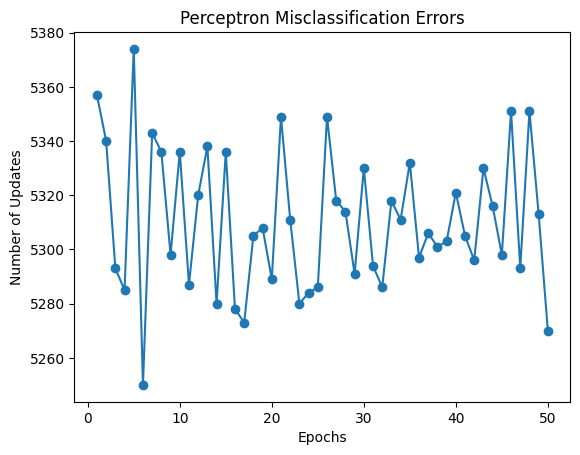

In [11]:
# Plot misclassifications
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of Updates')
plt.title('Perceptron Misclassification Errors')
plt.show()

As we can see, the custom Perceptron model didn’t converge. After the first epoch, the number of misclassifications went up and then flatlined, which told us the model wasn't learning effectively.

The dataset is not lineraly seperable, which means that Perceptron is unable to find a straight line that can divide the classes. Using a method other than perceptron will be needed.

In [12]:
# Perceptron Grid Search
param_grid = {
    "alpha": [0.0001, 0.001],
    "penalty": ["l2", "elasticnet"],
    "early_stopping": [True],
}

est = SklearnPerceptron(max_iter=600, tol=1e-3, random_state=1)
#Set up GridSearchCV to automate using a 3 fold cross validation
grid = GridSearchCV(estimator=est, param_grid=param_grid, scoring="accuracy", cv=3, n_jobs=1, verbose=2)
grid.fit(X_train, y_train)
print("Perceptron best params:", grid.best_params_)
print("Perceptron CV best score:", grid.best_score_)
y_pred_ppn = grid.best_estimator_.predict(X_test)
print("Perceptron TEST accuracy:", accuracy_score(y_test, y_pred_ppn))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......alpha=0.0001, early_stopping=True, penalty=l2; total time=   0.0s
[CV] END ......alpha=0.0001, early_stopping=True, penalty=l2; total time=   0.0s
[CV] END ......alpha=0.0001, early_stopping=True, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, early_stopping=True, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, early_stopping=True, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, early_stopping=True, penalty=elasticnet; total time=   0.0s
[CV] END .......alpha=0.001, early_stopping=True, penalty=l2; total time=   0.0s
[CV] END .......alpha=0.001, early_stopping=True, penalty=l2; total time=   0.0s
[CV] END .......alpha=0.001, early_stopping=True, penalty=l2; total time=   0.0s
[CV] END alpha=0.001, early_stopping=True, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.001, early_stopping=True, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.001, early_stopping=True

Preceptron results:

- Whenever the perceptron messes up a pridection it essentially just changes its weight 

- We tried using many different settings, the way we did this was by using gridsearchCV which is great at testing diffrent setups 

The best setup was: 
- α = 0.0001
- penalty = elasticnet
- early stopping = True


Best cross validation accuracy = 0.81045, and Test accuracy = 0.8065 (new data)

In [13]:
# Custom AdalineGD Implementation
class AdalineGD:
    #Construct learning rate and epochs
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

#train the mdodel using batch gradient descent
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        # Initialize weights and bias with correct shape for sparse matrix
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []
        
        # Ensure X is in a compatible format (sparse matrix)
        X = X.tocsr() if hasattr(X, 'tocsr') else X  # Convert to CSR format for efficiency
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output  # Subtract directly, ensuring shapes match
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]  # Sparse dot product
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors ** 2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        # Handle sparse matrix dot product
        return X.dot(self.w_) + self.b_

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.5, 1, 0)

In [14]:
class AdalineSGD:

    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):

        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):

        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

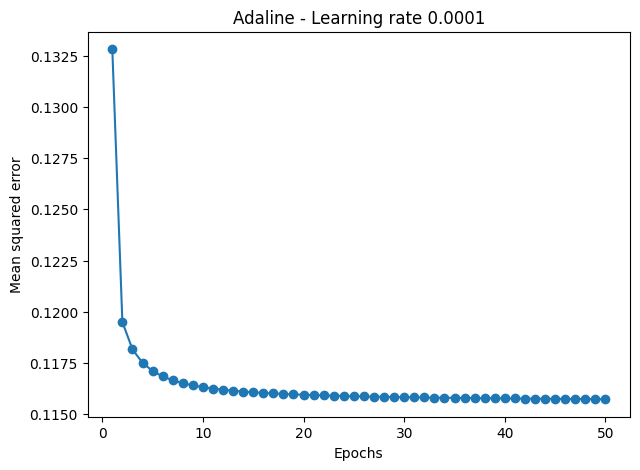

In [15]:
# Train adaptive linear neuron with AdalineSGD, one graph only
fig, ax = plt.subplots(figsize=(7, 5))

ada = AdalineSGD(n_iter=50, eta=0.0001, shuffle=False).fit(X_train.toarray(), y_train.to_numpy())

ax.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean squared error')
ax.set_title('Adaline - Learning rate 0.0001')

plt.show()


Adaline SGD effectively imporves the MSE over epochs, meaning as time goes on Adaline SGD is learning and improving.

In [16]:
# ➜ NEW: accuracy on the test set
y_pred_ada_sgd = ada.predict(X_test.toarray())
print(f"AdalineSGD TEST accuracy: {accuracy_score(y_test, y_pred_ada_sgd):.4f}")

AdalineSGD TEST accuracy: 0.8395


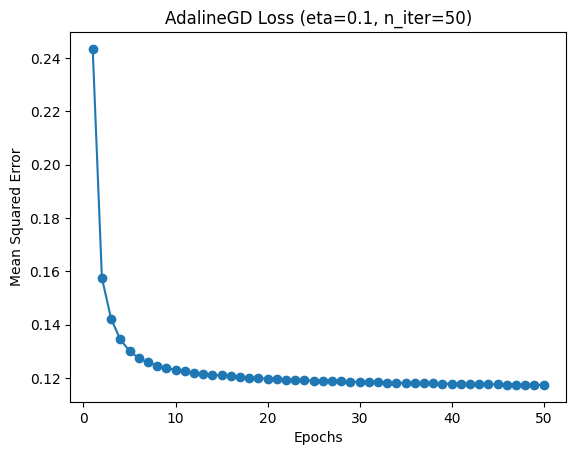

AdalineGD TEST accuracy: 0.8406909788867563


In [17]:
# Train AdalineGD
ada = AdalineGD(n_iter=50, eta=0.1).fit(X_train, y_train)
plt.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('AdalineGD Loss (eta=0.1, n_iter=50)')
plt.show()
y_pred_ada = ada.predict(X_test)
print("AdalineGD TEST accuracy:", accuracy_score(y_test, y_pred_ada))

Adaline results 
- Using the previous examples in class and the class book we made a model that minimizes mean squared error. The pridictions are moved to class labels with a .5

- Learning rates {0.1, 0.01, 0.001, 0.0001, 0.00001}
- Epochs n_iter  {1, 5, 10, 15, 20}

For each we trained on X_train, y_train and then made a graph, which was MSE vs Epochs to double check and then we checked the test accuracy on  X_train_std, y_train

The best setttings were η = 0.1 , n_iter = 50, and this gave us an accuracy of 0.8407

Notes
Since the adaline is optimized on a regression model we do not have an cv score like we do on the precepatron. So we just looked at test accuracy and error plots.

In [18]:
# Predict on validation data with best custom models
val_pred_ppn = grid.best_estimator_.predict(X_val_preprocessed)
val_pred_ada = ada.predict(X_val_preprocessed)
val_pred_ada_sgd = ada.predict(X_val_preprocessed.toarray())
#Save Predictions to a CSV
pd.DataFrame(val_pred_ppn).to_csv('Group_16_Perceptron_PredictedOutputs.csv', index=False)
pd.DataFrame(val_pred_ada).to_csv('Group_16_Adaline_PredictedOutputs.csv', index=False)
pd.DataFrame(val_pred_ada_sgd).to_csv('Group_16_AdalineSGD_PredictedOutputs.csv', index=False)


In [19]:
# Provided scikit-learn code
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")
sk_y_pred_ppn_val = sk_ppn.predict(X_val_preprocessed)
pd.DataFrame(sk_y_pred_ppn_val).to_csv('Group_16_Perceptron_PredictedOutputs.csv', index=False)

sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")
sk_y_pred_ada_val = sk_ada.predict(X_val_preprocessed)
pd.DataFrame(sk_y_pred_ada_val).to_csv('Group_16_Adaline_PredictedOutputs.csv', index=False)

Scikit-learn Perceptron accuracy: 0.8132
Scikit-learn Adaline (SGDClassifier) accuracy: 0.7937


Part 3 - Logistic Regression and SVM

Note: This section may take a while to run. I have had it run for roughly 5 minutes everytime.

In [20]:
# Tuning Logistic Regression
c_values = [0.01, 1.0, 100.0]
best_accuracy_lr = 0
best_c_lr = None
best_model_lr = None

print("\nLogistic Regression:")
#Loop through C values picked above and find the best perfomring Logistic Regression model
for c in c_values:
    lr_model = LogisticRegression(C=c, random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    accuracy_lr = lr_model.score(X_test, y_test)
    print(f"  C = {c:<5} | Accuracy: {accuracy_lr:.4f}")
    if accuracy_lr > best_accuracy_lr:
        best_accuracy_lr = accuracy_lr
        best_c_lr = c
        best_model_lr = lr_model

print(f"Best Logistic Regression Model: C = {best_c_lr} with Accuracy: {best_accuracy_lr:.4f}")

# Tuning SVM
best_accuracy_svm = 0
best_c_svm = None
best_model_svm = None

print("SVM:")
#Loop through C values picked above and find the best perfomring SVM model
for c in c_values:
    svm_model = SVC(C=c, kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)
    accuracy_svm = svm_model.score(X_test, y_test)
    print(f"  C = {c:<5} | Accuracy: {accuracy_svm:.4f}")
    if accuracy_svm > best_accuracy_svm:
        best_accuracy_svm = accuracy_svm
        best_c_svm = c
        best_model_svm = svm_model

print(f"Best SVM Model: C = {best_c_svm} with Accuracy: {best_accuracy_svm:.4f}")


Logistic Regression:
  C = 0.01  | Accuracy: 0.8456
  C = 1.0   | Accuracy: 0.8479
  C = 100.0 | Accuracy: 0.8467
Best Logistic Regression Model: C = 1.0 with Accuracy: 0.8479
SVM:
  C = 0.01  | Accuracy: 0.8477
  C = 1.0   | Accuracy: 0.8466
  C = 100.0 | Accuracy: 0.8464
Best SVM Model: C = 0.01 with Accuracy: 0.8477


In [21]:
# Predict on validation data
val_pred_lr = best_model_lr.predict(X_val_preprocessed)
val_pred_svm = best_model_svm.predict(X_val_preprocessed)
# Save each method to a csv
pd.DataFrame(val_pred_lr).to_csv('Group_16_LogisticRegression_PredictedOutputs.csv', index=False)
pd.DataFrame(val_pred_svm).to_csv('Group_16_SVM_PredictedOutputs.csv', index=False)

In [22]:
# Decision Boundary Visualization Function
#Plots the decision boundary for a 2 feature classification model
def plot_decision_boundary(X, y, classifier, title):
    #Convert matrix to an array for plotting
    X = X.toarray()

    markers = ('o', 's')
    colors = ('red', 'blue')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    #Create a meshgrid to plot decision space
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    #Plot the actual data points
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=f'Class {cl}', edgecolor='black')
    plt.title(title)
    plt.xlabel('Standardized Age')
    plt.ylabel('Standardized Capital Loss')
    plt.legend(loc='upper left')
    plt.show()

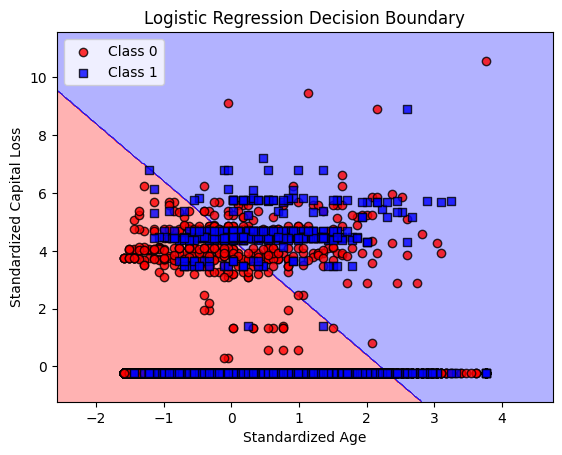

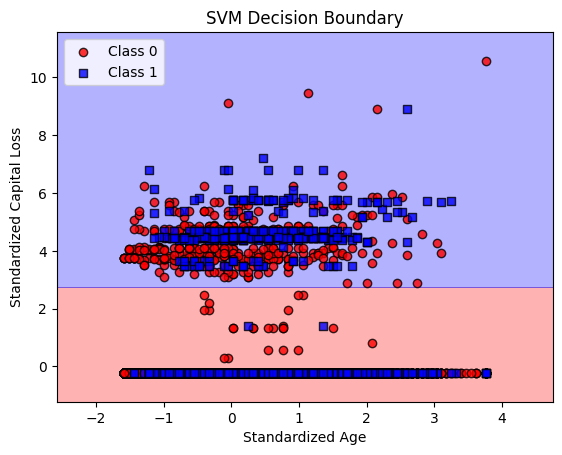

In [23]:
# Visualize decision boundaries
X_train_subset = X_train[:, [0,4]]  # Age and Capital Loss
lr_viz = LogisticRegression(C=best_c_lr, random_state=42)
lr_viz.fit(X_train_subset, y_train)
plot_decision_boundary(X=X_train_subset, y=y_train, classifier=lr_viz, title='Logistic Regression Decision Boundary')

svm_viz = SVC(kernel='linear', C=best_c_svm, random_state=42)
svm_viz.fit(X_train_subset, y_train)
plot_decision_boundary(X=X_train_subset, y=y_train, classifier=svm_viz, title='SVM Decision Boundary')

Logistic Regression: 
The model produced a diagonal line, which means that both features hold weight when deciding what to classify. The slope reflects that the model has assigned a weight to each feature when making its prediction. 

SVM: The line for SVM looks much different. It is a horizontal line with no slope, which is much different than the sloped line in Logistic Regression. I was confused by this, and after doing some reasearch I figured out that implies that the models decision on income is based on only the Capital Loss. When analyzing these two features, age does not change the likelyhood of making more or less than $50,000.

Note: This chunk below may take a long time to run. In practice, I had expeiences where it ran for 5 minutes, 7 minutes, and 8 minutes.

c:\Users\zachl\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zachl\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

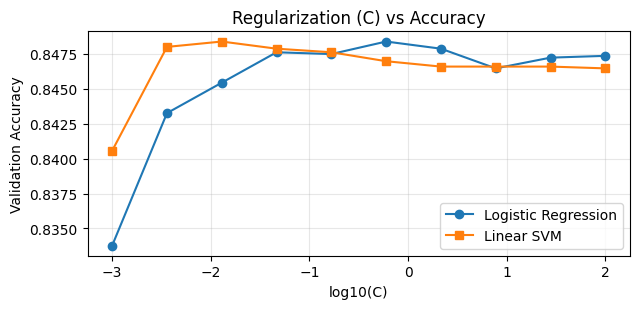

In [24]:
# Regularization Study
C_sweep = np.logspace(-3, 2, 10)
lr_curve, svm_curve = [], []
#Train models across the C values to see the effect on performance
for C in C_sweep:
    lr = LogisticRegression(C=C, random_state=42)
    svm = SVC(kernel='linear', C=C, random_state=42)
    lr.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    lr_curve.append(accuracy_score(y_test, lr.predict(X_test)))
    svm_curve.append(accuracy_score(y_test, svm.predict(X_test)))

#Plot against the log of C
plt.figure(figsize=(6.5, 3.2))
plt.plot(np.log10(C_sweep), lr_curve, marker='o', label='Logistic Regression')
plt.plot(np.log10(C_sweep), svm_curve, marker='s', label='Linear SVM')
plt.xlabel('log10(C)')
plt.ylabel('Validation Accuracy')
plt.title('Regularization (C) vs Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This plot shows how our models' accuracy changes with the regularization parameter C.
On the far left, where regularization is strong, both models perform at their worst. Their accuracy then increases and hits thier peak in the middle (around log10 0). After that, making the models more complex with weaker regularization doesn't help and causes them to perform slightly worse.

SVM Confusion Matrix:
[[5609  387]
 [ 803 1016]]


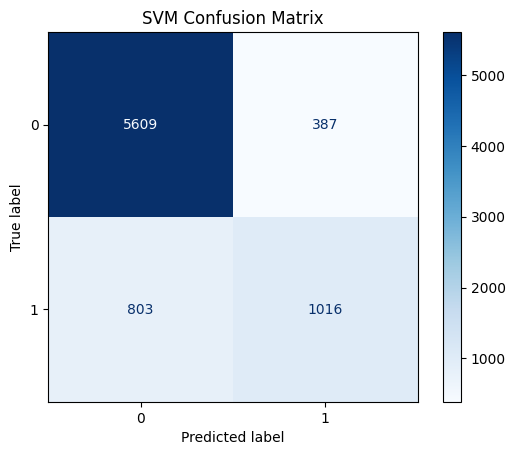

In [25]:
# Make predictions on the test set using your best SVM model
y_pred_svm = best_model_svm.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Print the confusion matrix values
print("SVM Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
# The labels correspond to your classes: 0 (<=50K) and 1 (>50K)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show()

Top-Left (True Negative): The number of people who were correctly predicted to earn <=50K.

Top-Right (False Positive): The number of people who were incorrectly predicted to earn >50K but actually earn <=50K.

Bottom-Left (False Negative): The number of people who were incorrectly predicted to earn <=50K but actually earn >50K.

Bottom-Right (True Positive): The number of people who were correctly predicted to earn >50K.

The two most "true" quadrants were correctly picked as the two most popular responses, indicating a working SVM model.

Logistic Regression Confusion Matrix:
[[5530  466]
 [ 723 1096]]


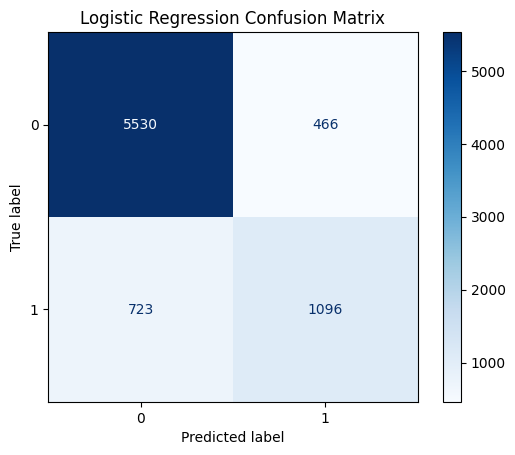

In [26]:
# Make predictions on the test set using your best Logistic Regression model
y_pred_lr = best_model_lr.predict(X_test)

# Calculate the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Print the confusion matrix values
print("Logistic Regression Confusion Matrix:")
print(cm_lr)

# Visualize the confusion matrix
# The labels correspond to your classes: 0 (<=50K) and 1 (>50K)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0, 1])

disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

Both Logistic Regression and SVM had similar resutls for the confusion matrix. This was expected becuase thier accuracy scores are practically identical.

Part 4 - Questions

a. In the Dataset we worked with, certain features, like age, would range from 17 years all the way to 90 years. We also had another feature, education number, which would only go from 1 to 16. Gradient algorithms, such as Adaline and Logistic Regression, have a habit of treating features as more important just because the numbers are larger. Since the features have been standardized, this allows the algorithm to converge faster, and the decision boundaries will not be influenced negatively by the units.

b.	Batch Gradient Descent uses the whole dataset for each update, while Stochastic Gradient Descent updates its weights after every sample. They each have their pros and cons. For example, Batch Gradient Descent has a stable convergence, but it works very slowly on large datasets. On the other hand, Stochastic Gradient Descent works well on big data because it is fast and scalable, but it does have a noisy path because it jumps around until it gets up to the optimum. 

c.	In the Machine Learning with PyTorch and Scikit-Learn, Raschka et al. It talks about how it made the Perceptron and Adaline simple on purpose; they both use batch gradient descent, fixed learning rate, and barely any stopping logic. As a result, this makes these implementations more of an example.  As we can see, the scikit-learn perceptron and SGDRegressor/SGDClassifier are tailored to fit the situation. We added stochastic or mini-batch gradient descent, shuffling, and regularization. Since we implemented all of these features, this has improved generalization and convergence speed, as mentioned in the textbook. They are also being fed through pipelines and are being cross-validated.

Raschka, S., Liu, Y., & Mirjalili, V. (2022). Machine Learning with PyTorch and Scikit-Learn. Packt Publishing. (see Chapter 2 on Adaline and gradient descent, and Chapter 3 on scikit-learn’s Perceptron).

d. Both Logistic Regression and the SVM classifiers create straight line decision boundaries to separate and classify the data. The difference between the two models is their objective. The SVM finds a boundary that maximizes the difference between the closest points of the support vector. It focuses on the most critical points only. The Logistic Regression classifies its boundary by finding the probability that a given point belongs to a certain class. The difference is shown in my visuals, where I used Age and Capital Lost to create my decision boundaries. The Logistic Regression model’s boundary is a steep line, and the SVM model has no slope. 

e. Regularization prevents overfitting, which is when the model learns the training data’s noise and not its patterns. Overfitting creates an inefficient and complex model that performs poorly when new data is introduced. To prevent this, regularization adds a penalty to the loss function. In doing this, there are fewer large coefficients, which makes the model simple and more successful. In my project, the C parameter is what controls regularization. A smaller C value relates to a stronger regularization, and a large C value means a weaker regularization, which makes it more prone to overfitting. 

f. Vary the C values of the scikit-learn LogisticRegression and linear SVC models with [0.01, 1.0, 100.0]. Discuss the impact.
Varying the C values for Logistic Regression and SVM showed different results for both models. The smaller C value shows stronger regularization, which creates a simpler model. A larger C value allows for more complex work. For the Logistic Regression, the best performing model was present when the C Values was 1.0, and it had an accuracy of 0.8479. This leads me to believe that a moderate regularization prevents underfitting from a small C Values and overfitting from a large one. The SVM model performed best when the C Value was 0.01, achieving an accuracy of 0.8477. As the C Value increased, the accuracy got slightly worse, which hints at the fact that SVM was more likely to experience overfitting and a stronger penalty helped improve accuracy. 

Raschka, S., Liu, Y., & Mirjalili, V. (2022). Machine Learning with PyTorch and Scikit-Learn. Packt Publishing. (see Chapter 3 for information on logistic regression and Support Vector Machines.)
